In [2]:
import numpy as np
import pandas as pd
import CSSS as CSSS
import sqlalchemy as sq
import matplotlib.pyplot as plt
import pytz
import datetime as dt
import pickle as pk

% matplotlib inline

## Load Data
Load home and weather data, previously stored in Pickle files. 

Cursory plots shows that a some homes exhibit very correlated furnace and air conditioning energy use, possbily the use of fans in ducts. I may need to create a method for filtering out the furnace use that is associated with cooling. Possibly all heating use that is simultaneous with cooling is also cooling. 

There is also cooling consumption in February in some homes, it could be that the opposite is true, and for some homes fans are included on the air conditioning circuit. 

In [52]:
loaddata = pk.load(open('test.pkl', 'rb'))
homeids = np.unique(homes['dataid'])
print('There are %d homes in the dataset' % len(homeids))

There are 275 homes in the dataset


In [58]:
list(loaddata)

['dataid',
 'local_15min',
 'use',
 'gen',
 'air1',
 'air2',
 'air3',
 'airwindowunit1',
 'furnace1',
 'furnace2',
 'cooling']

In [59]:
## Make a heating and cooling column
loaddata['cooling'] = np.sum(loaddata[['air1','air2','air3','airwindowunit1']], axis = 1)
loaddata['heating'] = np.sum(loaddata[['furnace1','furnace2']], axis = 1)

In [95]:
loadgroup = loaddata[['dataid','use','gen','heating','cooling']].groupby("dataid")
loaddata_counts = loadgroup.count()
loaddata_means  = loadgroup.mean()
loaddata_counts.columns = ['count_' + d for d in loaddata_counts.columns]
loaddata_means.columns  = ['mean_' + d for d in loaddata_means.columns]
load_summary = pd.concat([loaddata_counts,loaddata_means], axis = 1)

In [97]:
load_summary = load_summary.loc[load_summary['count_use'] == np.max(load_summary['count_use']),:]

In [102]:
print('There are %d homes with complete data' % load_summary.shape[0])
print('%d homes solar' % np.sum(load_summary['count_gen']>0))
print('%d homes cooling' % np.sum(load_summary['count_cooling']>0))
print('%d homes heating' % np.sum(load_summary['count_heating']>0))

There are 243 homes with complete data
There are 140 homes solar
There are 204 homes cooling
There are 172 homes heating


(735785.0, 735789.0)

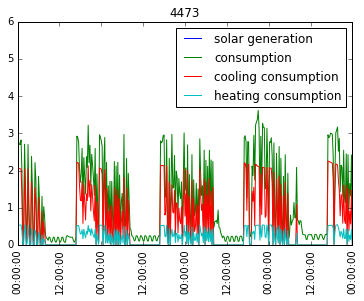

In [148]:
fig = plt.figure()
ax = plt.gca()

dataid = np.random.choice(load_summary.index, size=1)[0]

data = loaddata.groupby('dataid').get_group(dataid)
start = dt.datetime(2015,7,6)
dur   = dt.timedelta(days = 4)

ax.plot(data['local_15min'],-data['gen'], label = 'solar generation')
ax.plot(data['local_15min'],data['use'], label = 'consumption')
ax.plot(data['local_15min'],data['cooling'], label = 'cooling consumption')
ax.plot(data['local_15min'],data['heating'], label = 'heating consumption')
ax.set_title(dataid)
ax.legend()

plt.xticks(rotation = 90)

ax.set_xlim(start, start + dur)

## Climate Data
Load Appropriate Climate Data from Pecan Street.  There is no way to identify which homes belong to which datase.  There are only three locations, I'll pull all of them. 

In [128]:
weather = pk.load(open('weather.pkl', 'rb'))

(35037, 10)